In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [55]:
metadata_dir = 'updated_metadata.csv'

annotations = pd.read_csv(metadata_dir)

# Distribución de los datos teniendo en cuenta el hallazgo

In [79]:
def zip_by_column(column: str) -> dict[str, dict]:
    split_distribution: dict[str, dict] = {}
    for column_values, split in zip(annotations[column], annotations['split']):
        split_distribution.setdefault(split, {})
        column_value = eval(column_values) if column == 'finding_categories' else [ column_values ]
        for category in column_value:
            category = str(category)
            split_distribution[split].setdefault(category, int(0))
            split_distribution[split][category] += 1
    return split_distribution

In [80]:
split_finding_distribution = zip_by_column('finding_categories')

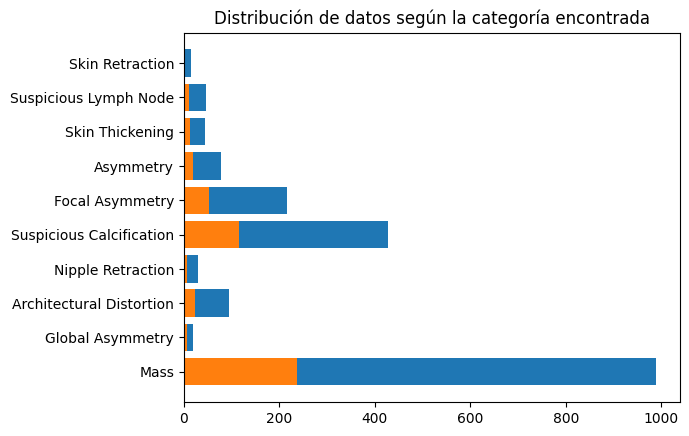

In [81]:
for split in split_finding_distribution:
    if 'No Finding' in split_finding_distribution[split]:
        del split_finding_distribution[split]['No Finding']

fig, ax = plt.subplots()
ax.set_title('Distribución de datos según la categoría encontrada')

height = 0.8
for boolean, weight_count in split_finding_distribution.items():
    ax.barh(weight_count.keys(), weight_count.values(), height, label=boolean)
plt.show()

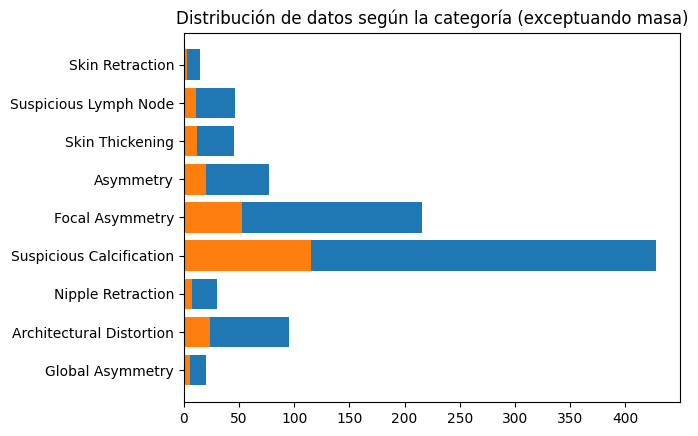

In [86]:
for split in split_finding_distribution:
    if 'Mass' in split_finding_distribution[split]:
        del split_finding_distribution[split]['Mass']

fig, ax = plt.subplots()
ax.set_title('Distribución de datos según la categoría (exceptuando masa)')

height = 0.8
for boolean, weight_count in split_finding_distribution.items():
    ax.barh(weight_count.keys(), weight_count.values(), height, label=boolean)
plt.show()

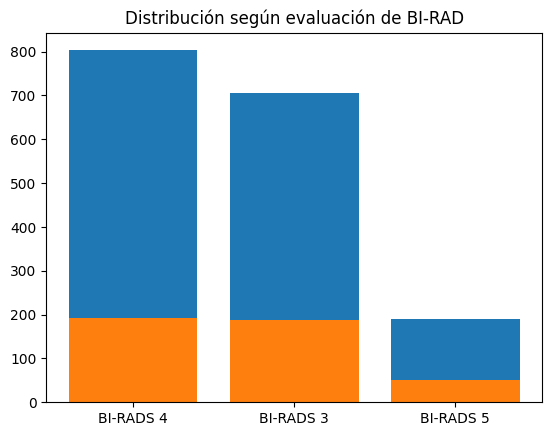

In [85]:
split_birads_distribution = zip_by_column('finding_birads')

for split in split_birads_distribution:
    if 'nan' in split_birads_distribution[split]:
        del split_birads_distribution[split]['nan']

fig, ax = plt.subplots()
ax.set_title('Distribución según evaluación de BI-RAD')

height = 0.8
for boolean, weight_count in split_birads_distribution.items():
    ax.bar(weight_count.keys(), weight_count.values(), height, label=boolean)
plt.show()

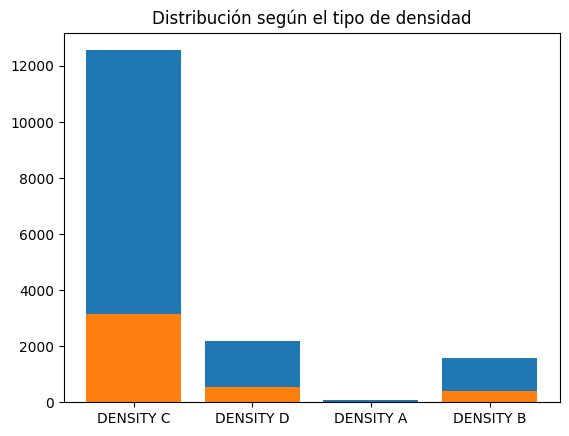

In [106]:
split_density_distribution = zip_by_column('breast_density')

# for split in split_density_distribution:
#     if 'nan' in split_density_distribution[split]:
#         del split_density_distribution[split]['nan']

fig, ax = plt.subplots()
ax.set_title('Distribución según el tipo de densidad')

height = 0.8
for boolean, weight_count in split_density_distribution.items():
    ax.bar(weight_count.keys(), weight_count.values(), height, label=boolean)
plt.show()

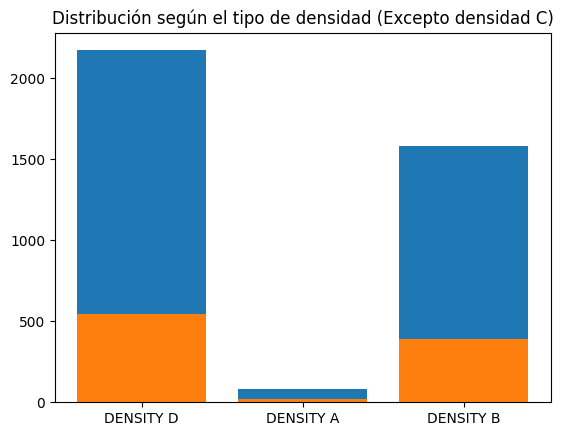

In [88]:
for split in split_density_distribution:
    if 'DENSITY C' in split_density_distribution[split]:
        del split_density_distribution[split]['DENSITY C']

fig, ax = plt.subplots()
ax.set_title('Distribución según el tipo de densidad (Excepto densidad C)')

height = 0.8
for boolean, weight_count in split_density_distribution.items():
    ax.bar(weight_count.keys(), weight_count.values(), height, label=boolean)
plt.show()

In [ ]:
%pip install pydicom
%pip install matplotlib
%pip install numpy
%pip install pandas

0.0 2143.0


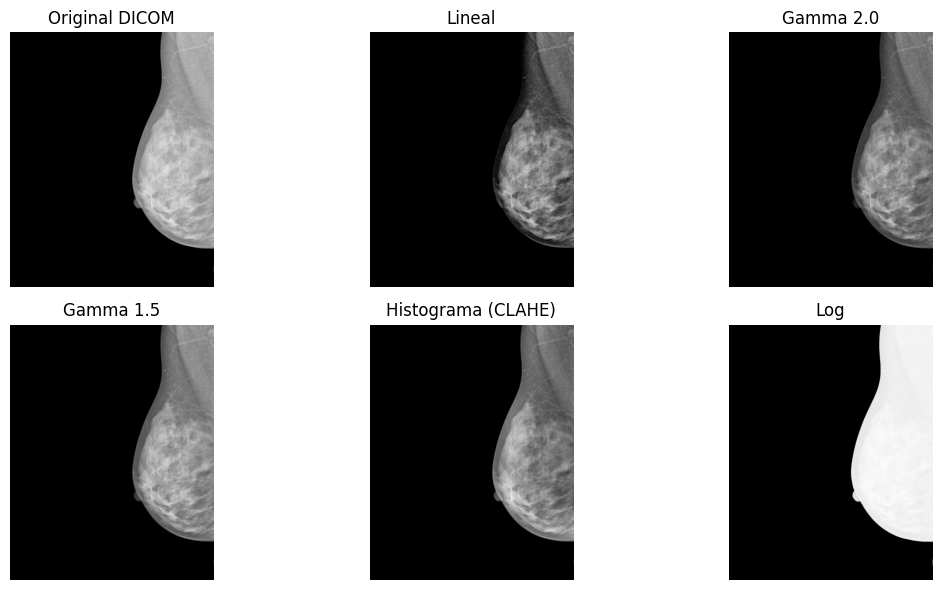

0.0 3463.0


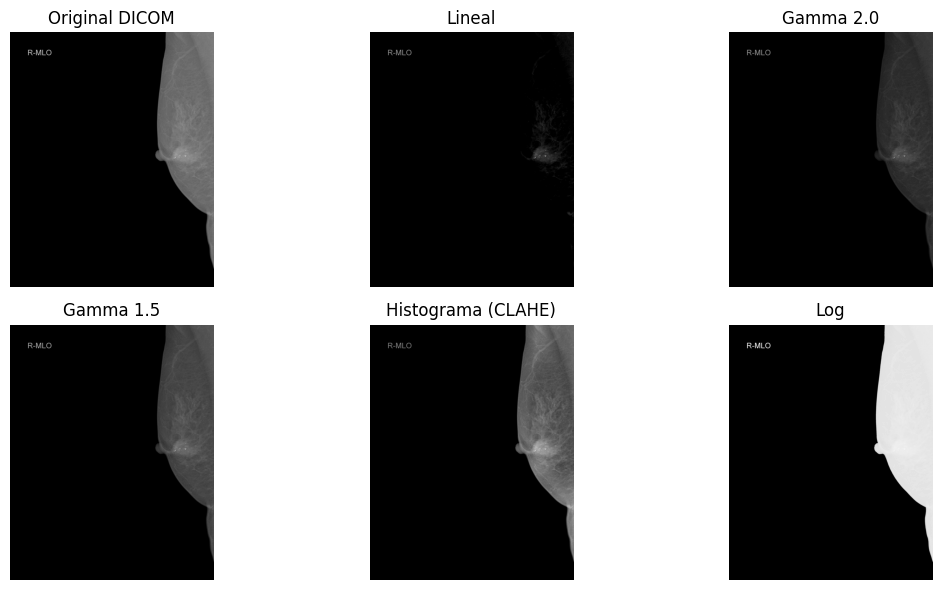

0.0 2112.0


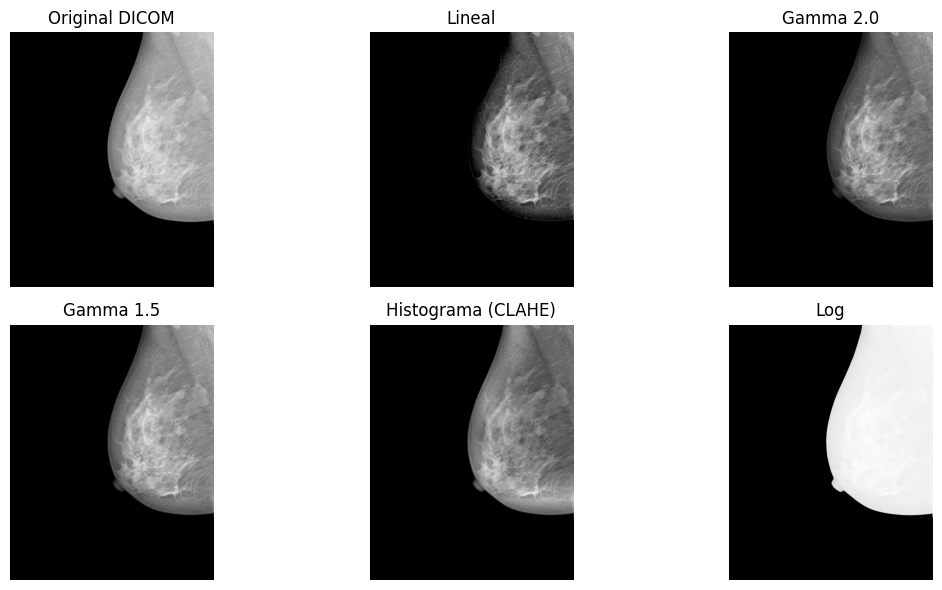

In [ ]:
import pydicom as dicom
import os
import matplotlib.pyplot as plt
import numpy as np
import cv2

def listdir(path):
    return [os.path.join(path, file) for file in os.listdir(path)]

images = [dicom.dcmread(image_path) for image_path in listdir('images')[:3]]

for image_data in images:
    image = image_data.pixel_array.astype(np.float32)

    min_val, max_val = image.min(), image.max()

    # Elimina el texto de la esquina superior izquierda
    image = np.where(image == max_val, 0, image)

    max_val = image.max()

    print(min_val, max_val)
    
    # 1. Tranformación lineal
    alpha = 1.8
    beta = -max_val * 0.8
    linear_transformed = np.clip(alpha * image + beta, min_val, max_val)


    # 2. Corrección Gamma (exponencial)
    gamma = 2.0
    gamma_corrected_2 = np.power(image / max_val, gamma) * max_val

    gamma = 1.5
    gamma_corrected_1_5 = np.power(image / max_val, gamma) * max_val

    # 3. Ecualización de Histograma (Usando CLAHE)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    hist_eq = clahe.apply(image.astype(np.uint16))


    # 4. Transformación logaritmica
    c = (max_val - min_val) / np.log(max_val - min_val)
    log_transformed = c * np.log(1 + image)



    # Presentación
    titles = ['Original DICOM', 'Lineal', 'Gamma 2.0', 'Gamma 1.5', 'Histograma (CLAHE)', 'Log']
    images = [image, linear_transformed, gamma_corrected_2, gamma_corrected_1_5, hist_eq, log_transformed]

    plt.figure(figsize=(12, 6))
    for i in range(len(titles)):
        plt.subplot(2, 3, i+1)
        plt.imshow(images[i], cmap='gray')
        plt.title(titles[i])
        plt.axis('off')

    plt.tight_layout()
    plt.show()
